# Simple Examples of Pytorch

## Import the pacakges we need to use

* Numpy: a matlab-like matrix tool for handling the data
* torch: package for building and training the Neural Network, it can also be used to build the simple model.
* torch.nn: there are many sub-functions in torch, e.g torch.nn, torch.nn.functional, this is just for convenient in the code.
* matplotlib: a matlib-like toolbox for ploting the data

In this part, simple usage of those packages are explained

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### Numpy

Numpy package is a tool to help you handle the data just like in Matlab

https://numpy.org/

In [8]:
# Create a 2D numpy array
a = np.array([
    [1,2,3],
    [4,5,6]
])
print("Original numpy array:")
print(a)

Original numpy array:
[[1 2 3]
 [4 5 6]]


In [ ]:
# plus
a = np.array([1,2,3])
b = np.array([4,5,6])
c = a + b
print("\nNumpy addition result:")
print(c)

In [ ]:
# multiply
a = np.array([1,2,3])
b = np.array([4,5,6])
c = a * b
print("\nNumpy multiplication result:")
print(c)

In [ ]:
# matrix multiplication
a = np.array([[1,2,3]])
b = np.array([[4],[5],[6]])
print("\nshape of a:", a.shape)
print("shape of b:", b.shape)
c = np.matmul(a, b)
print("\nNumpy matrix multiplication result:")
print(c)

### Matplotlib

https://matplotlib.org/

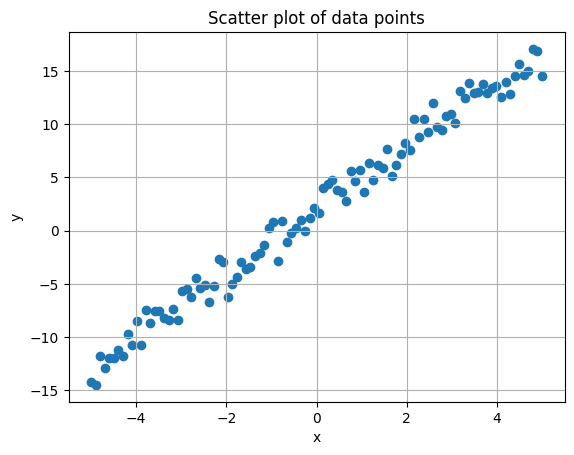

In [111]:
# Generate the data with numpy and plot it with matplotlib
x = np.linspace(-5,5,100)
n = np.random.randn(100)
y = 3*x + 2 + n

plt.scatter(x,y)
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.title("Scatter plot of data points")
plt.show()

In [112]:
# Create a PyTorch tensor
x_tensor = torch.tensor(x, dtype=torch.float32).view(-1,1)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1,1)
print("Tensor shape:", x_tensor.shape)
print("First 5 elements of x_tensor:", x_tensor[:5])

Tensor shape: torch.Size([100, 1])
First 5 elements of x_tensor: tensor([[-5.0000],
        [-4.8990],
        [-4.7980],
        [-4.6970],
        [-4.5960]])


## Example 1

Before building the NN, I want to explain first the Pytorch can not only used in the NN. As long as it's the gradient-based optimization algorithm, the Pytorch can be a good toolbox.

This is an example for $y=3x+2$. We simulate a period of time-series signal $s = y+n$, where n is the noise. Then, we can apply the Pytorch with the function of auto-gradient computation to fit the parameters $a=3$ and $b=2$. It can be expressed as

\begin{aligned}
    L &= ( y - (ax + b) )^{2} \\
    a &= a - \alpha \frac{\partial{L}}{\partial{a}} \\
    b &= b - \alpha \frac{\partial{L}}{\partial{b}}
\end{aligned}

### Bulil the model with pytorch

In [113]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        # Define parameter a and parameter b for y = ax + b
        self.a = nn.Parameter(torch.randn(1))
        self.b = nn.Parameter(torch.randn(1))
            
    def forward(self, x):
        return self.a * x + self.b

### Build the dataset

In [114]:
"""First, we need to generate x and y"""
x = np.linspace(-5,5,100)
n = np.random.randn(100)
y = 3*x + 2 + n

"""Merge x and y into a dataset of tuples"""
x = x.reshape(-1,1)
y = y.reshape(-1,1)
dataset = np.concatenate([x,y], axis=1)
dataset = torch.tensor(dataset, dtype=torch.float32)
print("Dataset shape:", dataset.shape)


Dataset shape: torch.Size([100, 2])


## Training and prediction

In [115]:
def fit(
    model,
    dataset, 
    lr,
    lr_steps
):
    for step in range(lr_steps):
        total_loss = 0
        for x, y in dataset:
            y_pred = model.forward(x)
            loss = (y_pred - y).pow(2).mean()
            total_loss += loss.item()

            loss.backward()

            with torch.no_grad():
                model.a -= lr * model.a.grad
                model.b -= lr * model.b.grad

                model.a.grad.zero_()
                model.b.grad.zero_()
        print(f"Step {step+1}/{lr_steps}, Loss: {total_loss/len(dataset)}")

    return model

In [116]:
"""Train the model"""
model = LinearModel()
model = fit(
    model,
    dataset,
    lr=0.01,
    lr_steps=10
)

Step 1/10, Loss: 3.767306790894072
Step 2/10, Loss: 1.1555770472297444
Step 3/10, Loss: 1.0127885602206517
Step 4/10, Loss: 0.9969050188671917
Step 5/10, Loss: 0.9943954224549816
Step 6/10, Loss: 0.9938437698597682
Step 7/10, Loss: 0.9936998309224054
Step 8/10, Loss: 0.9936600658684944
Step 9/10, Loss: 0.9936486171345882
Step 10/10, Loss: 0.9936456986114086


x_numpy shape: (100, 1) 
y_numpy shape: (100, 1) 
p_numpy shape: (100, 1)
predicted a: 2.9467244148254395 
predicted b: 2.0312142372131348


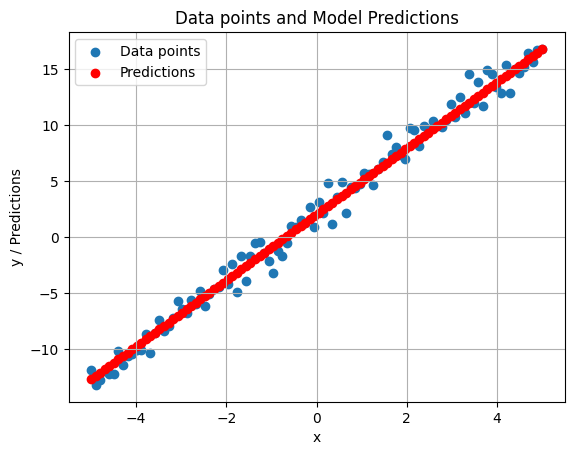

In [117]:
"""Prediction after training"""
x_tensor, y_tensor = dataset[:,0:1], dataset[:,1:2]
p_tensor = model(x_tensor)

x_numpy, y_numpy = x_tensor.detach().numpy(), y_tensor.detach().numpy()
p_numpy = p_tensor.detach().numpy()

print(
    "x_numpy shape:", x_numpy.shape,"\n"
    "y_numpy shape:", y_numpy.shape,"\n"
    "p_numpy shape:", p_numpy.shape
)

plt.scatter(np.squeeze(x_numpy), np.squeeze(y_numpy), label="Data points")
plt.scatter(np.squeeze(x_numpy), np.squeeze(p_numpy), color='r', label="Predictions")
plt.xlabel("x")
plt.ylabel("y / Predictions")
plt.legend()
plt.grid()
plt.title("Data points and Model Predictions")

print(
    "predicted a:", model.a.item(), "\n"
    "predicted b:", model.b.item()
)

## Example 2

This is an example for classification. We assume there are two kinds of signals (noise signal and cyclostationary signal):

\begin{aligned}
    s_1(t) &= n(t), \\
    s_2(t) &= a(1+0.5*\sin(2\pi f t)) + n(t), \\
\end{aligned}

where, $n(t) \sim \mathcal{N}\{0, \sigma_{n}^{2}\}$ and $a \sim \mathcal{N}\{0, \sigma_{a}^{2}\}$.

### Data Simulation

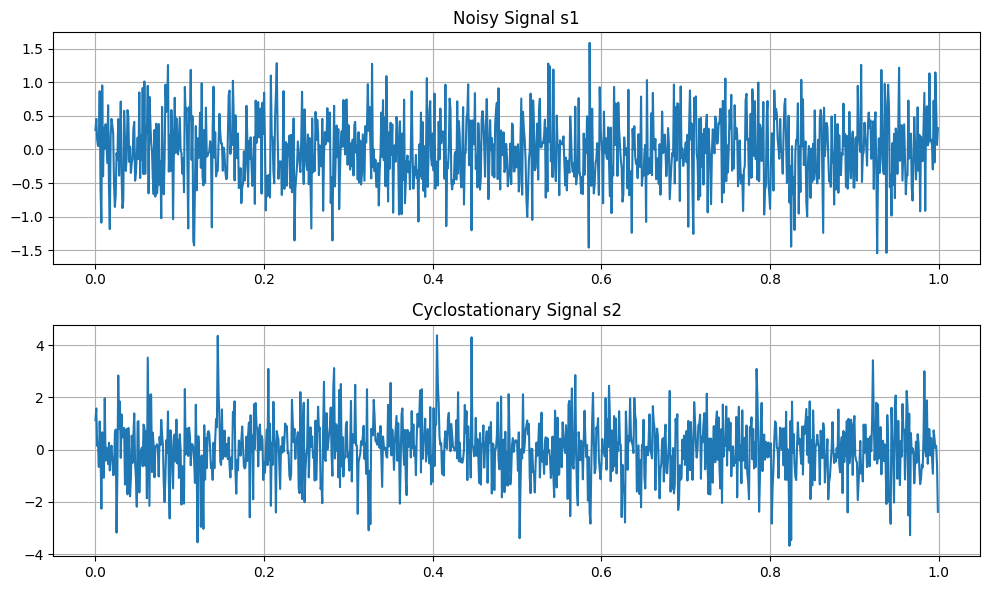

In [118]:
""" Generate synthetic signals with numpy """
# frequency sampling and time duration
fs = 1000
cyclostationary_fs = 50
time = 100
# standard deviations
sigma_a = 1
sigma_n = 0.5
# time vector and amplitude modulation
t = np.arange(fs*time) / fs
a = np.random.randn(fs*time)
# noisy signals
s1 = np.random.randn(fs*time) * sigma_n
# cyclostationary signal
env = 1 + 0.5*np.sin(2*np.pi*cyclostationary_fs*t)  # 周期包络
s2 = (env * np.random.randn(fs*time) * sigma_a) + np.random.randn(fs*time) * sigma_n
# s2 = a*np.sin(2*np.pi*cyclostationary_fs*t) + np.random.randn(fs*time) * sigma_n

# plot the first second of the signals
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.title("Noisy Signal s1")
plt.plot(t[:1000], s1[:1000])
plt.grid()
plt.subplot(2,1,2)
plt.title("Cyclostationary Signal s2")
plt.plot(t[:1000], s2[:1000])
plt.grid()
plt.tight_layout()
plt.show()


For the envelope spectrum, we can find obvious cyclostationary frequency

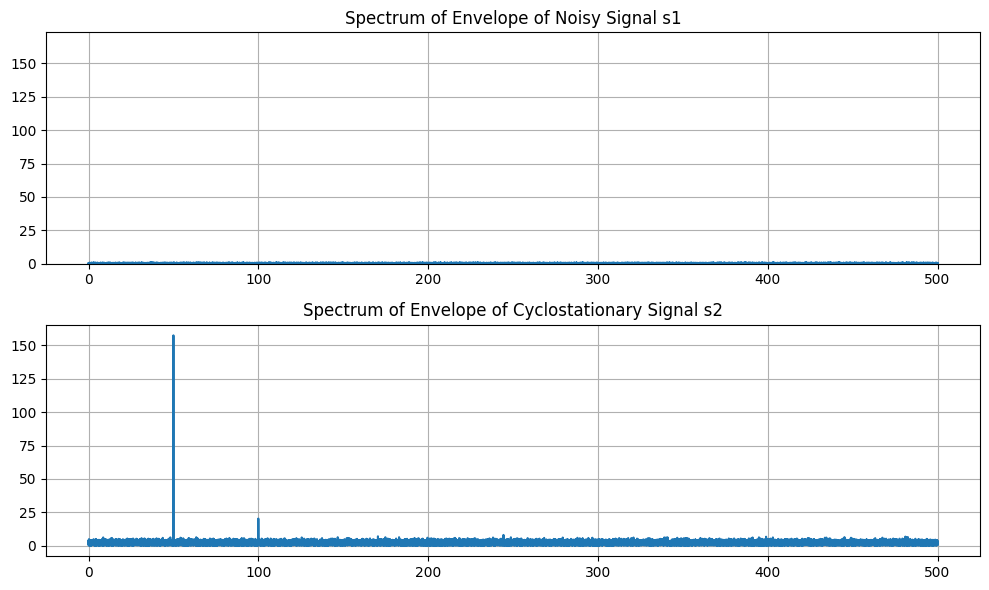

In [119]:
# plot the envelope of the cyclostationary signal
s1_envelope = s1 ** 2
spectrum_s1 = np.fft.rfft(s1_envelope, norm="ortho")[1:]

s2_envelope = s2 ** 2
spectrum_s2 = np.fft.rfft(s2_envelope, norm="ortho")[1:]

freqs = np.fft.rfftfreq(len(s2_envelope), 1/fs)
freqs = freqs[1:]

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.title("Spectrum of Envelope of Noisy Signal s1")
plt.plot(freqs, np.abs(spectrum_s1))
plt.ylim(0, np.max(np.abs(spectrum_s2))*1.1)
plt.grid()
plt.subplot(2,1,2)
plt.title("Spectrum of Envelope of Cyclostationary Signal s2")
plt.plot(freqs, np.abs(spectrum_s2))
plt.grid()
plt.tight_layout()
plt.show()

### Build dataset

In [120]:
s1_tensor = torch.tensor(s1, dtype=torch.float32)
s2_tensor = torch.tensor(s2, dtype=torch.float32)

# first 70% for training, last 30% for testing
train_size = int(0.7 * len(s1_tensor))
s1_train = s1_tensor[:train_size]
s1_test = s1_tensor[train_size:]

s2_train = s2_tensor[:train_size]
s2_test = s2_tensor[train_size:]

We could slide the 100 seconds signal into segments, the segments would be the input of the NN. After sliding the signal into segments, we select the 70% percentage part of the signal as the training dataset, then the left 30% percentage as the test dataset

In [121]:
# create train segments
segment_length = 1000
overlap = 0.75
def fold_signal(signal, segment_length, overlap):
    step = int(segment_length * (1 - overlap))
    segments = []
    for start in range(0, len(signal) - segment_length + 1, step):
        segment = signal[start:start + segment_length]
        segments.append(segment)
    return torch.stack(segments)

s1_segments_train = fold_signal(s1_train, segment_length, overlap)
s2_segments_train = fold_signal(s2_train, segment_length, overlap)

s1_segments_train = torch.fft.rfft(s1_segments_train**2, norm="ortho")[:,1:].abs()
s2_segments_train = torch.fft.rfft(s2_segments_train**2, norm="ortho")[:,1:].abs()  

label_s1_train = torch.zeros(s1_segments_train.shape[0], dtype=torch.long)
label_s2_train = torch.ones(s2_segments_train.shape[0], dtype=torch.long)

print("s1_segments shape:", s1_segments_train.shape)
print("s2_segments shape:", s2_segments_train.shape)

s1_segments shape: torch.Size([277, 500])
s2_segments shape: torch.Size([277, 500])


In [122]:
# create test segments
s1_segments_test = fold_signal(s1_test, segment_length, overlap)
s2_segments_test = fold_signal(s2_test, segment_length, overlap)

s1_segments_test = torch.fft.rfft(s1_segments_test**2, norm="ortho")[:,1:].abs()
s2_segments_test = torch.fft.rfft(s2_segments_test**2, norm="ortho")[:,1:].abs()

label_s1_test = torch.zeros(s1_segments_test.shape[0], dtype=torch.long)
label_s2_test = torch.ones(s2_segments_test.shape[0], dtype=torch.long)

print("s1_segments_test shape:", s1_segments_test.shape)
print("s2_segments_test shape:", s2_segments_test.shape)

s1_segments_test shape: torch.Size([117, 500])
s2_segments_test shape: torch.Size([117, 500])


Next, we can finally build the train dataset and test dataset. Here, we could use the torch package TensorDataset and DataLoader to help us

In [123]:
# build the dataset and dataloader with torch.utils.data.TensorDataset and DataLoader
segments_train = torch.cat([s1_segments_train, s2_segments_train], dim=0)
label_train = torch.cat([label_s1_train, label_s2_train], dim=0)
dataset_train = torch.utils.data.TensorDataset(
    segments_train,
    label_train
)

segments_test = torch.cat([s1_segments_test, s2_segments_test], dim=0)
label_test = torch.cat([label_s1_test, label_s2_test], dim=0)
dataset_test = torch.utils.data.TensorDataset(
    segments_test,
    label_test
)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=False)

# how to use the dataset
for i in range(len(dataset_train)):
    data, label = dataset_train[i]
    if i < 2:
        print(f"Sample {i}: data shape: {data.shape}, label: {label}")
    else:
        break

print("\n")

# how to use the dataloader
for batch_data, batch_labels in dataloader_train:
    print("Batch data shape:", batch_data.shape)
    print("Batch labels shape:", batch_labels.shape)
    break

Sample 0: data shape: torch.Size([500]), label: 0
Sample 1: data shape: torch.Size([500]), label: 0


Batch data shape: torch.Size([32, 500])
Batch labels shape: torch.Size([32])


### Model Building

In [124]:
class SimpleDenseNN(nn.Module):
    def __init__(self):
        super(SimpleDenseNN, self).__init__()
        self.fc1 = nn.Linear(500, 100)
        self.fc2 = nn.Linear(100, 10)
        self.fc3 = nn.Linear(10, 1)  # Assuming binary classification
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        out = self.sigmoid(out)

        return out

### Training and  Prediction

For the optimizer, we here use the random gradient decent. For the loss function, we use the Binary Cross Entropy loss function

$$
Loss = -\frac{1}{N}\sum_{i=1}^{N}\left[y_{i}\log(p_{i})+(1-y_{i})\log(1-p_{i})\right]
$$

In [125]:
model = SimpleDenseNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for batch_data, batch_labels in dataloader_train:
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs.squeeze(), batch_labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader_train)}")

Epoch [1/10], Loss: 0.5163240962558322
Epoch [2/10], Loss: 0.44576456480556065
Epoch [3/10], Loss: 0.36748109261194867
Epoch [4/10], Loss: 0.31684081421958077
Epoch [5/10], Loss: 0.27769120285908383
Epoch [6/10], Loss: 0.21724898450904423
Epoch [7/10], Loss: 0.15730500055683982
Epoch [8/10], Loss: 0.1310777867005931
Epoch [9/10], Loss: 0.11838050145241949
Epoch [10/10], Loss: 0.10919126330150498


Have a look at the accuracy

\begin{align}
\text{Accuracy}=\frac{1}{N}\sum_{i=1}^{N}\mathbf{1}\left(p_i=y_i\right)
\end{align}

In [ ]:
prediction_train = model(segments_train)
prediction_test = model(segments_test)

prediction_train = (prediction_train.squeeze() > 0.5).long()
prediction_test = (prediction_test.squeeze() > 0.5).long()

accuracy_train = (prediction_train == label_train).float().mean().item()
accuracy_test = (prediction_test == label_test).float().mean().item()
print(
    f"Training Accuracy: {accuracy_train*100:.2f}%, "
    f"Test Accuracy: {accuracy_test*100:.2f}%"
)

Training Accuracy: 100.00%, Test Accuracy: 100.00%
